# Dataset bajo Bag of Visual Words

Este notebook de Python tratará la creación del archivo con la cual se entrenará la red FeedForward para cada característica (si es vehículo o no, el tipo de vehículo y la marca del mismo), recuerde cambiar los datos con los cuales se hará al momento de inicializar el algoritmo.

In [3]:
#Importamos las librerías de costumbre
import numpy as np
import pandas as pd
#Instalamos la librería que nos va a permitir bajar de drive
!pip install gdown
import gdown
#Colocamos la URL del archivo
url = 'https://drive.google.com/uc?id=1tY5Nkrr7mEvkXjrlWPHyzx9DoDZhSD2l'
#Colocamos el nombre al archivo donde la información será guardada
Nombre = '../Datasets/Vehiculos.rar'
#Lo descargamos
gdown.download(url,Nombre,quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1tY5Nkrr7mEvkXjrlWPHyzx9DoDZhSD2l
To: /home/slbejaranom/work/home/ConteoEIdentificacionDeTrafico/Datasets/Vehiculos.rar
44.3MB [00:06, 7.14MB/s]


'../Datasets/Vehiculos.rar'

In [9]:
#Una vez descargado lo extraemos, para eso hacemos uso de las librerías patool y pyunpack
!pip install patool pyunpack
from pyunpack import Archive

#Extraemos
Archive('../Datasets/Vehiculos.rar').extractall('../Datasets')
print("Extraído satisfactoriamente")

Extraído satisfactoriamente


In [7]:
#Ahora vamos a pasar a la parte sucia, para eso primero instalamos opencv contrib
!pip install opencv-contrib-python
import cv2
import os

     |████████████████████████████████| 55.7 MB 8.9 MB/s eta 0:00:01


In [10]:
#Damos el nombre de la carpeta en la que se encuentra el dataset
dataset = "../Datasets/Vehiculos"
#Para las clases lo que hacemos es listar los nombres de las carpetas que se encuentran por dentro, se listan en orden alfabético
training_names = os.listdir(dataset)

#Ahora vamos a tener las variables para todas las imágenes
#La variable image_paths guardará las rutas de las imágenes
image_paths = []
image_classes = []
class_id = 0

def imglist(path):
    return [os.path.join(path,f) for f in os.listdir(path)]

for training_name in training_names:
    dir = os.path.join(dataset, training_name)
    class_path = imglist(dir)
    image_paths += class_path
    image_classes += [class_id]*len(class_path)
    class_id += 1

In [11]:
#Ahora crearemos una lista para tener la lista de descriptores que hallaremos a partir del SIFT
des_list = []
#Creamos el extractor SIFT con 50 puntos clave por imagen
sift = cv2.SIFT_create(50)
#Cogemos cada imagen, le pasamos el SIFT y los apilamos en des_list de la siguiente manera
#NOMBRE DEL ARCHIVO, DESCRIPTORES
for image_path in image_paths:
    im = cv2.imread(image_path)
    kpts, des = sift.detectAndCompute(im, None)
    des_list.append((image_path,des))

In [12]:
#Ahora vamos a apilar todos los descriptores de manera vertical
descriptors = des_list[0][1]
#Hay que descartar los descriptores que son None
for image_path, descriptor in des_list[1:]:
    if descriptor is not None:
        descriptors = np.vstack((descriptors, descriptor))
        
#Para hacer K Means es necesario que los datos estén en tipo float por lo que la siguiente linea es necesaria
descriptors_float = descriptors.astype(float)

## K Means
Acá viene la parte del K Means, en esta sección es necesario el estudio del codo en la gráfica para saber qué valor de K podríamos utilizar que no sea de gasto computacional pero que tampoco quite exactitud

In [13]:
from scipy.cluster.vq import kmeans, vq

varianzas = []
num_clusters = range(100,5000,100)

for k in num_clusters:
    centroide, varianza = kmeans(descriptors_float, k, 1)
    varianzas.append(varianza)


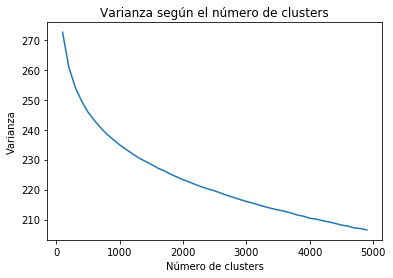

In [14]:
elbow_plot_data = pd.DataFrame({'num_clusters':num_clusters,
                               'disortions':varianzas})

import seaborn as sns
from matplotlib import pyplot as plt

sns.lineplot(x = 'num_clusters',y = 'disortions', data = elbow_plot_data)

plt.xlabel("Número de clusters")
plt.ylabel("Varianza")
plt.title("Varianza según el número de clusters")
plt.show()

In [15]:
#Con 1500 clusters ya podríamos obtener una buena división ya que luego baja a una tasa más lenta.
k = 1500
voc, variance = kmeans(descriptors_float,k,2)

In [16]:
#Creamos un vector de características vacío
im_features = np.zeros((len(image_paths),k),"float32")
#Ahora procedemos a obtener los histogramas para cada imagen
for i in range(len(image_paths)):
    if des_list[i][1] is not None:
        words, distance = vq(des_list[i][1],voc)
        for w in words:
            im_features[i][w] += 1

In [17]:
#Hacemos la vectorización Tf-Idf
nbr_ocurrences = np.sum((im_features > 0)*1, axis = 0)
idf = np.array(np.log((1.0*len(image_paths)+1)/(1.0*nbr_ocurrences + 1)), "float32")

In [18]:
#Lo próximo que haremos será normalizar los valores
from sklearn.preprocessing import StandardScaler
stdSlr = StandardScaler().fit(im_features)
im_features = stdSlr.transform(im_features)
#Después de esto ya tenemos listo para guardar el archivo CSV

In [19]:
#Esto lo hacemos para tener salidas y entradas en un mismo arreglo para generar el CSV
DataSet = []
for i in range(len(image_classes)):
    DataSet.append(np.append(im_features[i],image_classes[i]))

In [20]:
#Guardamos el dataset
pd.DataFrame(DataSet).to_csv("DataSet_NoVehiculo_Vehiculo.csv", header=False, index=False)

In [21]:
#Guardamos la configuración (El Standard Scaler y el K con el que hicimos el K Means)
!pip install joblib
import joblib
joblib.dump((stdSlr,k,voc),"Config_BoVW_NoV_V.pkl",compress = 3)

['Config_BoVW_NoV_V.pkl']